In [1]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import bilby
import scipy.signal as sig
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters

02:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


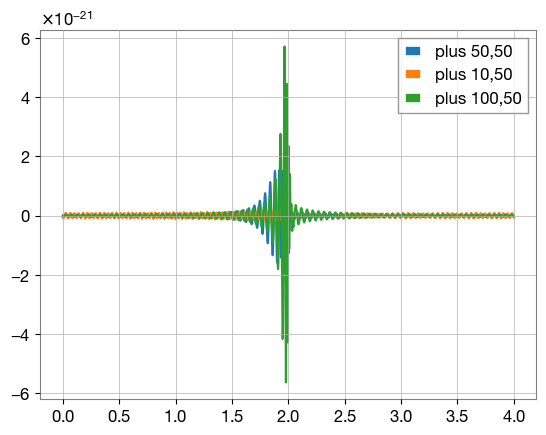

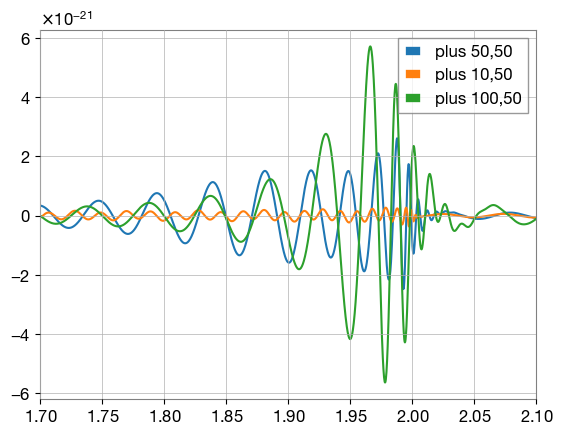

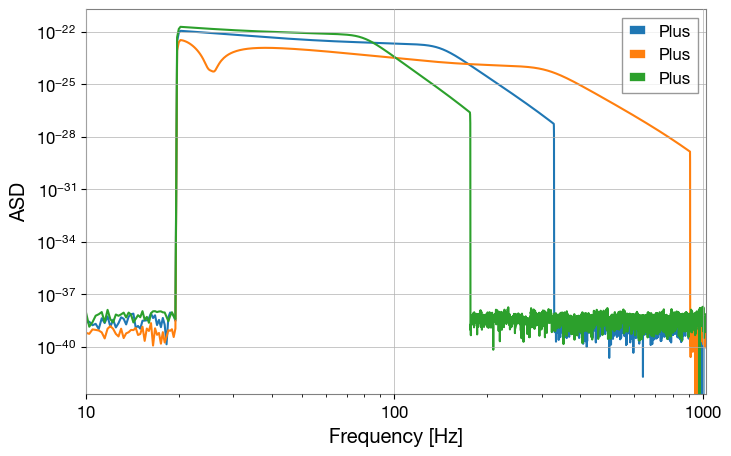

In [426]:
duration = 4.#4s
sampling_frequency = 4096.#Hz
waveform_arguments = {
    'waveform_approximant': 'IMRPhenomPv2',
    'reference_frequency': 50.,  # most sensitive frequency
    'minimum_frequency': 20.
}
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    frequency_domain_source_model=lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

def generateWaveForm(iM1,iM2):
    injection_parameters = dict(
    #mass_1=iM1, mass_2=iM2, 
    chirp_mass=iM1, mass_ratio=iM2,
    a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=500, theta_jn=0., psi=0.,
    phase=0.2, geocent_time=1243309096, ra=0., dec=0.)
    polarizations_td = waveform_generator.time_domain_strain(injection_parameters)
    return polarizations_td

def shiftplus(iPolar,sampling,duration):
    plus_td  = np.roll(iPolar['plus'],  int(sampling * duration/2.))
    cross_td = np.roll(iPolar['cross'], int(sampling * duration/2.))
    return plus_td
    
polarizations_td0 = generateWaveForm(50,0.5)
polarizations_td1 = generateWaveForm(10,0.1)
polarizations_td2 = generateWaveForm(100,0.9)

plus_td0=shiftplus(polarizations_td0,sampling_frequency,duration)
plus_td1=shiftplus(polarizations_td1,sampling_frequency,duration)
plus_td2=shiftplus(polarizations_td2,sampling_frequency,duration)

#plus_td0 = np.roll(polarizations_td0['plus'], int(sampling_frequency * 2))
#time = np.linspace(0., duration, len(plus_td0))

plt.plot(time, plus_td0, label='plus 50,50')
plt.plot(time, plus_td1, label='plus 10,50')
plt.plot(time, plus_td2, label='plus 100,50')
plt.legend()
plt.show()

plt.plot(time, plus_td0, label='plus 50,50')
plt.plot(time, plus_td1, label='plus 10,50')
plt.plot(time, plus_td2, label='plus 100,50')
plt.legend()
plt.xlim(1.7,2.1)
plt.show()

# And their ASD
def asd(its):
    NFFT = int(4 * sampling_frequency)
    freq, plus_psd = sig.welch(its, fs=sampling_frequency, nperseg=NFFT)
    plus_asd = np.sqrt(plus_psd)
    return freq,plus_asd

freq0,plus_asd0 = asd(plus_td0)
freq1,plus_asd1 = asd(plus_td1)
freq2,plus_asd2 = asd(plus_td2)

fig = plt.figure(figsize=(8, 5))
plt.loglog(freq0, plus_asd0, label='Plus')
plt.loglog(freq1, plus_asd1, label='Plus')
plt.loglog(freq2, plus_asd2, label='Plus')
plt.xlim(10, 1024)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.legend()
plt.show()

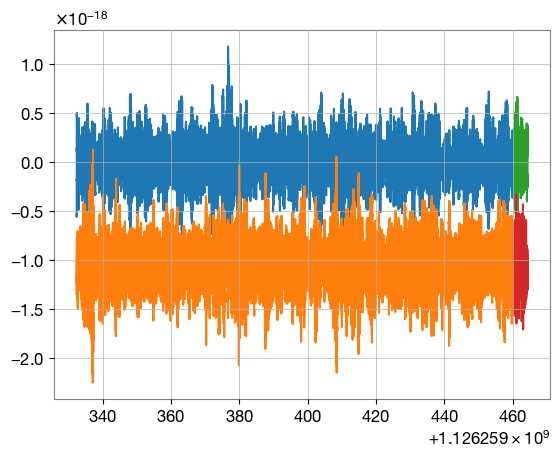

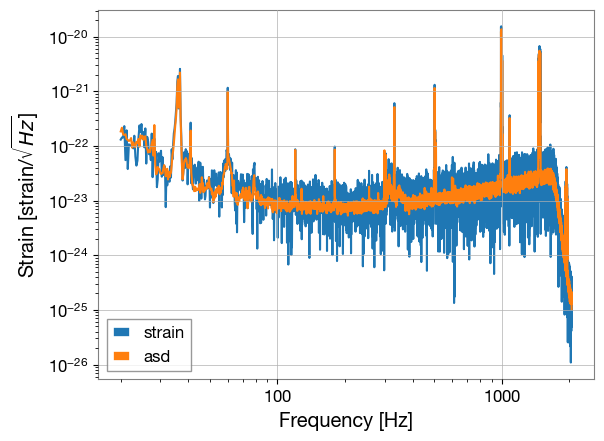

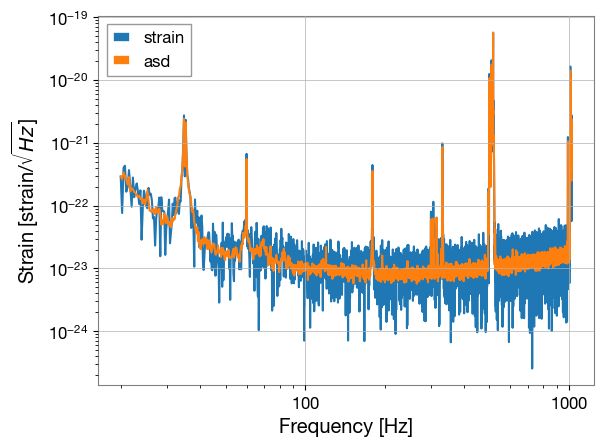

In [151]:
from gwpy.timeseries import TimeSeries

time_of_event = 1126259462.413

H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration
psd_alpha = 2 * H1.strain_data.roll_off / duration


#ok so get the data we are going to use for the fit
H1_analysis_data = TimeSeries.fetch_open_data("H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)
L1_analysis_data = TimeSeries.fetch_open_data("L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

# Use gwpy to fetch the open data and get the data around the time to compute the psd
H1_psd_data = TimeSeries.fetch_open_data( "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)
L1_psd_data = TimeSeries.fetch_open_data( "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)
plt.plot(H1_psd_data)
plt.plot(L1_psd_data)
plt.plot(H1_analysis_data)
plt.plot(L1_analysis_data)
plt.show()

#Set this to our model
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

#Now compute the PSDs and set this 
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],np.abs(H1.strain_data.frequency_domain_strain[idxs]),label='strain')
ax.loglog(H1.power_spectral_density.frequency_array[idxs], H1.power_spectral_density.asd_array[idxs],label='asd')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.legend()
plt.show()

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

fig, ax = plt.subplots()
idxs = L1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(L1.strain_data.frequency_array[idxs],np.abs(L1.strain_data.frequency_domain_strain[idxs]),label='strain')
ax.loglog(L1.power_spectral_density.frequency_array[idxs], L1.power_spectral_density.asd_array[idxs],label='asd')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.legend()
plt.show()


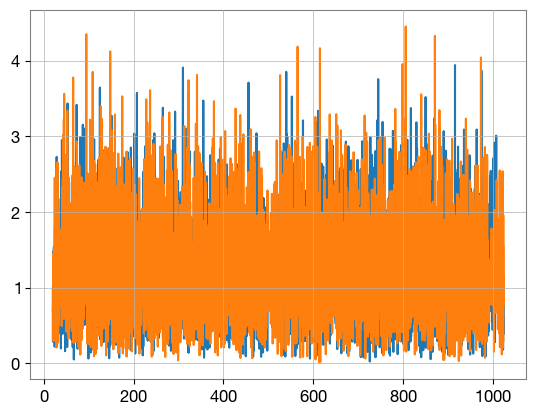

In [20]:
H1ratio=np.abs(H1.strain_data.frequency_domain_strain[idxs])/H1.power_spectral_density.asd_array[idxs]
L1ratio=np.abs(L1.strain_data.frequency_domain_strain[idxs])/L1.power_spectral_density.asd_array[idxs]
plt.plot(L1.strain_data.frequency_array[idxs],L1ratio,label='strain')
plt.plot(L1.strain_data.frequency_array[idxs],H1ratio,label='strain')
plt.show()

09:47 bilby WARNING : Injecting signal outside segment, start_time=1126259460.4128418, merger time=1243309096.
09:47 bilby INFO    : Injected signal in H1:
09:47 bilby INFO    :   optimal SNR = 13.16
09:47 bilby INFO    :   matched filter SNR = 15.89+0.85j
09:47 bilby INFO    :   mass_1 = 20
09:47 bilby INFO    :   mass_2 = 20
09:47 bilby INFO    :   a_1 = 0.0
09:47 bilby INFO    :   a_2 = 0.0
09:47 bilby INFO    :   tilt_1 = 0.0
09:47 bilby INFO    :   tilt_2 = 0.0
09:47 bilby INFO    :   phi_12 = 0.0
09:47 bilby INFO    :   phi_jl = 0.0
09:47 bilby INFO    :   luminosity_distance = 500
09:47 bilby INFO    :   theta_jn = 0.0
09:47 bilby INFO    :   psi = 0.0
09:47 bilby INFO    :   phase = 0.2
09:47 bilby INFO    :   geocent_time = 1243309096
09:47 bilby INFO    :   ra = 0.0
09:47 bilby INFO    :   dec = 0.0


{'plus': array([ 3.67435805e-22,  3.96614067e-22,  2.61180213e-22, ...,
       -4.93345399e-22, -1.74836384e-22,  1.55314917e-22]), 'cross': array([-2.55195550e-22,  2.34765552e-23,  2.39423681e-22, ...,
       -3.57490849e-22, -5.28204639e-22, -4.76848946e-22])}


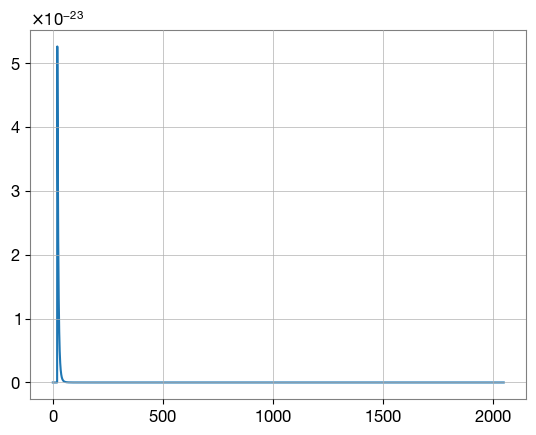

[False False False ... False False False]
[  20.     20.25   20.5  ... 1023.5  1023.75 1024.  ]
[  20.     20.25   20.5  ... 1023.5  1023.75 1024.  ]


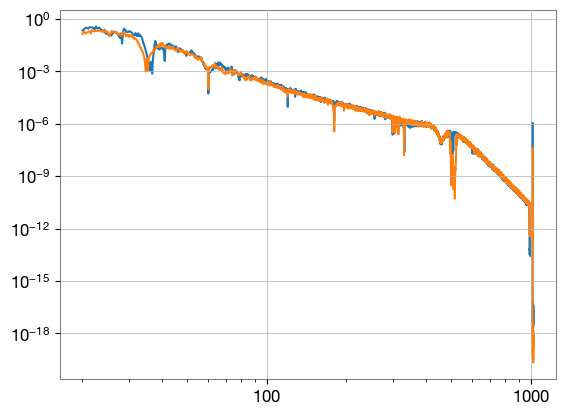

[  -74276.04472379 -5496283.71970837  3224257.01743562]
-0.013676271333765953


In [221]:
# And their ASD
def asd(its):
    NFFT = int(4 * sampling_frequency)
    freq, plus_psd = sig.welch(its, fs=sampling_frequency, nperseg=NFFT)
    plus_asd = np.sqrt(plus_psd)
    return freq,plus_asd

def generateWaveForm(iM1,iM2):
    injection_parameters = dict(
    mass_1=iM1, mass_2=iM2, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=500, theta_jn=0., psi=0.,
    phase=0.2, geocent_time=1243309096, ra=0., dec=0.)
    polarizations_td = waveform_generator.time_domain_strain(injection_parameters)
    print(polarizations_td)
    H1.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)
    return polarizations_td,H1

polarizations_td0,H1inj = generateWaveForm(20,20)
plus_td0=shiftplus(polarizations_td0,sampling_frequency,duration)
freq0,plus_asd0=asd(plus_td0)

plt.plot(freq0, plus_asd0, label='Plus')
plt.show()
print(idxs)
print(freq0[idxs])
print(L1.strain_data.frequency_array[idxs])


L1SigRatio=plus_asd0[idxs]/H1.power_spectral_density.asd_array[idxs]
H1SigRatio=plus_asd0[idxs]/L1.power_spectral_density.asd_array[idxs]

plt.loglog(L1.strain_data.frequency_array[idxs],L1SigRatio,label='strain')
plt.loglog(L1.strain_data.frequency_array[idxs],H1SigRatio,label='strain')
plt.show()

from bilby_cython.geometry import (
    get_polarization_tensor,
    three_by_three_matrix_contraction,
    time_delay_from_geocenter,
)

print(L1.vertex_position_geocentric())
print(time_delay_from_geocenter(H1.vertex_position_geocentric(), 0, 0, time_of_event))

1.986323728666234
1.9882081154873206


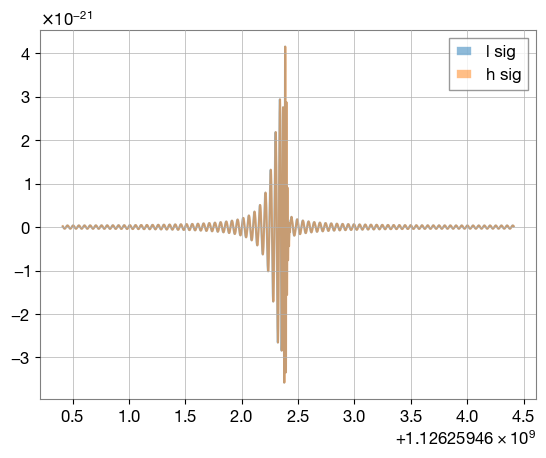

(16384,)


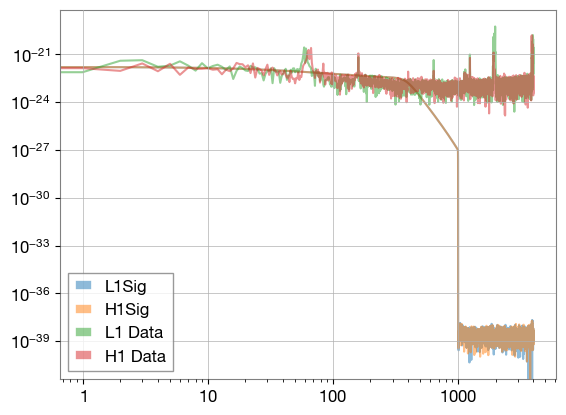

In [539]:
L1vtx = L1.vertex_position_geocentric()
H1vtx = H1.vertex_position_geocentric()
L1Data = np.abs(L1.strain_data.frequency_domain_strain[idxs])
H1Data = np.abs(H1.strain_data.frequency_domain_strain[idxs])

#waveform_generator = bilby.gw.WaveformGenerator(
#    duration=duration, sampling_frequency=sampling_frequency,
#    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
#    frequency_domain_source_model=lal_binary_black_hole,
#    waveform_arguments=waveform_arguments)

def generateWaveForm(iM1,iM2,iD):
    injection_parameters = dict(
    mass_1=iM1, mass_2=iM2, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=iD, theta_jn=0., psi=0.,
    phase=0.0, geocent_time=1243309096, ra=0., dec=0.)
    polarizations_td = waveform_generator.time_domain_strain(injection_parameters)
    return polarizations_td

def asdSig(iM1,iM2,iD,iDT):
    pol    = generateWaveForm(iM1,iM2,iD)
    print(iDT + duration/2.)
    shift  = np.roll(pol['plus'],  int(sampling_frequency * (duration/2. + iDT)))
    NFFT = int(4 * sampling_frequency)
    freq, psd = sig.welch(shift, fs=sampling_frequency, nperseg=NFFT)
    asd = np.sqrt(psd)
    return asd[idxs],shift

def asdSigBkg(iM1,iM2,iRA,iDC,iD):
    L1Time  =  time_delay_from_geocenter(L1vtx, iRA, iDC, time_of_event)
    H1Time  =  time_delay_from_geocenter(H1vtx, iRA, iDC, time_of_event)
    lL1SASD,_ = asdSig(iM1,iM2,iD,L1Time)
    lH1SASD,_ = asdSig(iM1,iM2,iD,H1Time)
    lH1BASD = H1.power_spectral_density.asd_array[idxs]
    lL1BASD = L1.power_spectral_density.asd_array[idxs]
    return (lL1SASD) + lL1BASD,(lH1SASD) + lH1BASD

#def loss(data1,data2,m1,m2,ra,dec,dist):
#    L1SB,H1SB = asdSigBkg(m1,m2,ra,dec,dist)
#    L1Chi2    = np.sum(((L1SB-data1)/L1.power_spectral_density.asd_array[idxs])**2)
#    H1Chi2    = np.sum(((H1SB-data2)/H1.power_spectral_density.asd_array[idxs])**2)
#    print("L1:",L1Chi2,"H1:",H1Chi2,"M1:",m1,"M2:",m2,"Mag:",dist)
#    return L1Chi2#(L1Chi2+H1Chi2)

def loss(data1,data2,m1,m2,ra,dec,dist):
    L1SB,H1SB = asdSigBkg(m1,m2,ra,dec,dist)
    L1Chi2    = np.vdot(np.conj(L1SB),data1/L1.power_spectral_density_array[idxs])
    H1Chi2    = np.vdot(np.conj(H1SB),data2/H1.power_spectral_density_array[idxs])
    L1Chi2S   = np.vdot(np.conj(L1SB),L1SB/L1.power_spectral_density_array[idxs])
    H1Chi2S   = np.vdot(np.conj(H1SB),H1SB/H1.power_spectral_density_array[idxs])
    #print("L1:",L1Chi2.real,"H1:",H1Chi2.real,"M1:",m1,"M2:",m2,"Mag:",dist)
    return (4./duration)*(L1Chi2+H1Chi2).real

def resid(params):
    #iM1,iM2,iRA,iDC,iMag):
    iM1   = params['m1'].value
    iM2   = params['m2'].value
    iRA   = params['ra'].value
    iDC   = params['dec'].value
    iD    = params['dist'].value
    L1SB,H1SB = asdSigBkg(iM1,iM2,iRA,iDC,iD)
    L1Chi2    = (L1SB-L1Data)/L1.power_spectral_density.asd_array[idxs]
    H1Chi2    = (H1SB-H1Data)/H1.power_spectral_density.asd_array[idxs]
    return np.append(L1Chi2,H1Chi2)

#def fft():
#    frequency_array, psd_array = strain.create_power_spectral_density(
#        fft_length=fft_length, name=name, outdir=outdir, overlap=overlap,
#        analysis_segment_start_time=analysis_segment_start_time)

L1dataWhite=L1_analysis_data.whiten(asd=np.sqrt(L1_psd))
H1dataWhite=H1_analysis_data.whiten(asd=np.sqrt(H1_psd))
L1ASD,L1Sig=asdSig(100,50,400,time_delay_from_geocenter(H1.vertex_position_geocentric(), 0, 0, time_of_event))
H1ASD,H1Sig=asdSig(100,50,400,time_delay_from_geocenter(L1.vertex_position_geocentric(), 0, 0, time_of_event))
L1Sig  =TimeSeries(L1Sig,t0=analysis_start,dt=1./sampling_frequency)
H1Sig  =TimeSeries(H1Sig,t0=analysis_start,dt=1./sampling_frequency)
#print(L1Sig)
#print(L1_analysis_data)
#L1SigWhite  =L1Sig.whiten(asd=np.sqrt(L1_psd))
#H1SigWhite  =H1Sig.whiten(asd=np.sqrt(H1_psd))
#dataWhite = whiten(L1Data,H1.power_spectral_density)
#plt.plot(np.fft.irfft(L1Data))
#plt.plot(L1_analysis_data)
#plt.plot(H1_analysis_data)
#plt.plot(L1dataWhite[8000:8300],alpha=0.5,label='l bkg')
#plt.plot(H1dataWhite[8000:8300],alpha=0.5,label='h bkg')
#plt.plot(L1dataWhite,alpha=0.5,label='l bkg')
#plt.plot(H1dataWhite,alpha=0.5,label='h bkg')
#plt.plot(L1Sig)
#plt.plot(H1Sig)
plt.plot(L1Sig,alpha=0.5,label='l sig')
plt.plot(H1Sig,alpha=0.5,label='h sig')
plt.legend()
plt.show()
print(L1SigWhite.shape)

plt.loglog(L1ASD,label='L1Sig',alpha=0.5)
plt.loglog(H1ASD,label="H1Sig",alpha=0.5)
plt.loglog(L1Data,label='L1 Data',alpha=0.5)
plt.loglog(H1Data,label='H1 Data',alpha=0.5)
plt.legend()
plt.show()



In [174]:
import lmfit 

model = lmfit.Model(loss)
params = model.make_params()#m1=50,m2=50,ra=0,dec=0,mag=0.001) 
#params["m1"] = 50
#params["m1"] = 50
print(params['m1'])
result = lmfit.minimize(resid, params)
lmfit.report_fit(result)

<Parameter 'm1', value=-inf, bounds=[-inf:inf]>
M1 -inf M2 -inf


XLAL Error - XLALSimIMRPhenomPCalculateModelParametersFromSourceFrame (LALSimIMRPhenomP.c:295): m1 must be positive.

XLAL Error - XLALSimIMRPhenomPCalculateModelParametersFromSourceFrame (LALSimIMRPhenomP.c:295): Input domain error
XLAL Error - PhenomPCore (LALSimIMRPhenomP.c:604): m1 must be positive.

XLAL Error - PhenomPCore (LALSimIMRPhenomP.c:604): Input domain error
XLAL Error - XLALSimIMRPhenomP (LALSimIMRPhenomP.c:514): Failed to generate IMRPhenomP waveform.
XLAL Error - XLALSimIMRPhenomP (LALSimIMRPhenomP.c:514): Internal function call failed: Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform (LALSimInspiral.c:2034): Internal function call failed: Input domain error


RuntimeError: Internal function call failed: Input domain error

In [220]:
from scipy.optimize import minimize

x0 = np.array([100,100,50])
def fun(inputs):
  lx=loss(L1Data,H1Data,inputs[0],inputs[1],0,0,inputs[2])
  return lx

cons= ({'type': 'ineq', 'fun': lambda x:  x[0]},
       {'type': 'ineq', 'fun': lambda x:  x[1]},
       {'type': 'ineq', 'fun': lambda x:  x[2]})
constraints=cons
bnds = ((0.1, None), (0.1, None), (10, None))
sol=minimize(fun,x0,bounds=bnds)

L1: 1829.132796197126 H1: 2479.573554010458 M1: 100.0 M2: 100.0 Mag: 50.0
L1: 1829.1327961973516 H1: 2479.5735540110572 M1: 100.00000001 M2: 100.0 Mag: 50.0
L1: 1829.1327961973516 H1: 2479.5735540110572 M1: 100.0 M2: 100.00000001 Mag: 50.0
L1: 1829.1327961966085 H1: 2479.5735540097107 M1: 100.0 M2: 100.0 Mag: 50.00000001
L1: 1829.1291147408454 H1: 2479.5669943786897 M1: 99.97744451723564 M2: 99.97744451723564 Mag: 50.05175024424904
L1: 1829.1291147410675 H1: 2479.5669943792905 M1: 99.97744452723563 M2: 99.97744451723564 Mag: 50.05175024424904
L1: 1829.1291147410675 H1: 2479.5669943792905 M1: 99.97744451723564 M2: 99.97744452723563 Mag: 50.05175024424904
L1: 1829.1291147403306 H1: 2479.5669943779485 M1: 99.97744451723564 M2: 99.97744451723564 Mag: 50.05175025424904
L1: 1828.730819574589 H1: 2479.0084023726918 M1: 98.45420907889047 M2: 98.45420907889047 Mag: 59.679992077362584
L1: 1828.7308195747655 H1: 2479.008402373127 M1: 98.45420908889047 M2: 98.45420907889047 Mag: 59.679992077362584

L1: 1785.11631949523 H1: 2274.613244975757 M1: 0.9200535496912546 M2: 0.9200535596912547 Mag: 73.83858655426754
L1: 1785.1163189307838 H1: 2274.6132416944492 M1: 0.9200535496912546 M2: 0.9200535496912546 Mag: 73.83858656426753
L1: 1785.0813624502803 H1: 2275.266932498679 M1: 0.919326441596624 M2: 0.919326441596624 Mag: 74.47383747250105
L1: 1785.0813623068252 H1: 2275.2669371237394 M1: 0.9193264515966241 M2: 0.919326441596624 Mag: 74.47383747250105
L1: 1785.0813623068252 H1: 2275.2669371237394 M1: 0.919326441596624 M2: 0.9193264515966241 Mag: 74.47383747250105
L1: 1785.0813624502905 H1: 2275.2669325182515 M1: 0.919326441596624 M2: 0.919326441596624 Mag: 74.47383748250104
L1: 1785.0793384735248 H1: 2275.368462802755 M1: 0.9194767420563389 M2: 0.9194767420563389 Mag: 74.45582563231216
L1: 1785.0793384820631 H1: 2275.368467265046 M1: 0.9194767520563389 M2: 0.9194767420563389 Mag: 74.45582563231216
L1: 1785.0793384820631 H1: 2275.368467265046 M1: 0.9194767420563389 M2: 0.9194767520563389 M

In [215]:
print(sol)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3942.241975962137
        x: [ 1.000e-01  1.000e-01  1.000e+01]
      nit: 6
      jac: [ 1.483e+05  1.483e+05  2.090e+01]
     nfev: 40
     njev: 10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [313]:
print(np.fft.rfft(L1_analysis_data).shape,L1_analysis_data.shape)
arr=np.arange(0,12,1)
sinarr=np.sin((arr+0.5)*np.pi*(1./12.))
print(sinarr,"\n",np.abs(np.fft.rfft(sinarr)),"\n",np.abs(np.fft.rfft(sinarr)))

(8193,) (16384,)
[0.13052619 0.38268343 0.60876143 0.79335334 0.92387953
 0.99144486 0.99144486 0.92387953 0.79335334 0.60876143
 0.38268343 0.13052619] 
 [7.66129758e+00 2.52408582e+00 4.85223149e-01 1.91103609e-01
 8.90401069e-02 3.68816199e-02 8.88178420e-16] 
 [7.66129758e+00 2.52408582e+00 4.85223149e-01 1.91103609e-01
 8.90401069e-02 3.68816199e-02 8.88178420e-16]


In [218]:
np.abs(H1.strain_data.frequency_domain_strain)

array([0., 0., 0., ..., 0., 0., 0.])

In [424]:
duration = 4.#4s
sampling_frequency = 4096.#Hz
waveform_arguments = {
    'waveform_approximant': 'IMRPhenomPv2',
    'reference_frequency': 50.,  # most sensitive frequency
    'minimum_frequency': 20.,
}
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    frequency_domain_source_model=lal_binary_black_hole,
    waveform_arguments=waveform_arguments)
injection_parameters = dict(
    mass_1=50, mass_2=50, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=500, theta_jn=0., psi=0.,
    phase=0.2, geocent_time=1243309096, ra=0., dec=0.)
polarizations_fd = waveform_generator.frequency_domain_strain(injection_parameters)
polarizations_td = waveform_generator.time_domain_strain(injection_parameters)
print(polarizations_td["plus"].shape,polarizations_fd["plus"].shape)
H1.get_detector_response(polarizations_fd,injection_parameters)

23:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


(16384,) (8193,)


array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [500]:
def acceptance(waveform_polarizations, parameters,iRA,iDEC,iTime,iDet):
    signal = {}
    mask=iDet.frequency_mask
    for mode in waveform_polarizations.keys():
        polarization_tensor = get_polarization_tensor(iRA, iDEC, time_of_event+iTime, 0, mode)
        det_response=three_by_three_matrix_contraction(iDet.geometry.detector_tensor, polarization_tensor)
        signal[mode] = waveform_polarizations[mode] * det_response
    signal_ifo = sum(signal.values()) * mask
    dt = iTime
    frequencies = iDet.frequency_array[mask]
    signal_ifo[mask] = signal_ifo[mask] * np.exp(-1j * 2 * np.pi * dt * frequencies)
    signal_ifo[mask] *= iDet.calibration_model.get_calibration_factor(frequencies, prefix='recalib_{}_'.format(iDet.name), **parameters)
    return signal_ifo[mask]
    
def generateWaveForm(iMc,iMR,iRA,iDC,iD):
    lMc = np.max([iMc,5.])
    lMR = np.max([iMR,0.01])
    lD  = np.max([iD,50.])
    injection_parameters = dict(
    chirp_mass=lMc, mass_ratio=lMR, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=lD, theta_jn=1.89694, psi=0.532268,
    phase=0.0, geocent_time=time_of_event, ra=iRA, dec=iDC)
    polarizations_fd = waveform_generator.frequency_domain_strain(injection_parameters)
    return polarizations_fd,injection_parameters

def asdSig(iM1,iM2,iD,iDT,iRA,iDC,iDet):
    pol,pars = generateWaveForm(iM1,iM2,iRA,iDC,iD)
    pol=acceptance(pol,pars,iRA,iDC,iDT,iDet)
    return pol

def asdSigBkg(iM1,iM2,iRA,iDC,iD):
    L1Time  =  time_delay_from_geocenter(L1vtx, iRA, iDC, time_of_event)
    H1Time  =  time_delay_from_geocenter(H1vtx, iRA, iDC, time_of_event)
    lL1SASD = asdSig(iM1,iM2,iD,L1Time,iRA,iDC,L1)
    lH1SASD = asdSig(iM1,iM2,iD,H1Time,iRA,iDC,H1)
    #lH1BASD = H1.power_spectral_density.asd_array[idxs]
    #lL1BASD = L1.power_spectral_density.asd_array[idxs]
    return (lL1SASD),(lH1SASD)

def loss(data1,data2,m1,m2,ra,dec,dist):
    L1SB,H1SB = asdSigBkg(m1,m2,ra,dec,dist)
    L1Chi2    = np.vdot(np.conj(L1SB),data1/L1.power_spectral_density_array[idxs])
    H1Chi2    = np.vdot(np.conj(H1SB),data2/H1.power_spectral_density_array[idxs])
    L1Chi2S   = np.vdot(np.conj(L1SB),L1SB/L1.power_spectral_density_array[idxs])
    H1Chi2S   = np.vdot(np.conj(H1SB),H1SB/H1.power_spectral_density_array[idxs])
    return (4./duration)*(L1Chi2-L1Chi2S+H1Chi2-H1Chi2S).real

def fun(inputs):
  lx=loss(L1Data,H1Data,inputs[0],inputs[1],2.19432,-1.2232,inputs[2])
  return lx

x0 = np.array([30,0.5,400])
cons= ({'type': 'ineq', 'fun': lambda x:  x[0]},
       {'type': 'ineq', 'fun': lambda x:  x[1]},
       {'type': 'ineq', 'fun': lambda x:  x[2]})
constraints=cons
bnds = ((0.1, None), (0.1, None), (10, None))
sol=minimize(fun,x0,bounds=bnds,method='Nelder-Mead', options={'gtol': 1e-3, 'disp': True})
print(sol)
#print(L1.frequency_array,H1.frequency_array)
#print(loss(L1Data,H1Data,10,20,0,0,300))


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_70505/523503105.py:58: OptimizeWarning: Unknown solver options: gtol
  sol=minimize(fun,x0,bounds=bnds,method='Nelder-Mead', options={'gtol': 1e-3, 'disp': True})


Optimization terminated successfully.
         Current function value: -29220.445291
         Iterations: 112
         Function evaluations: 208
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -29220.445290784028
             x: [ 6.887e+01  1.000e+00  3.414e+01]
           nit: 112
          nfev: 208
 final_simplex: (array([[ 6.887e+01,  1.000e+00,  3.414e+01],
                       [ 6.887e+01,  1.000e+00,  3.414e+01],
                       [ 6.887e+01,  1.000e+00,  3.414e+01],
                       [ 6.887e+01,  1.000e+00,  3.414e+01]]), array([-2.922e+04, -2.922e+04, -2.922e+04, -2.922e+04]))


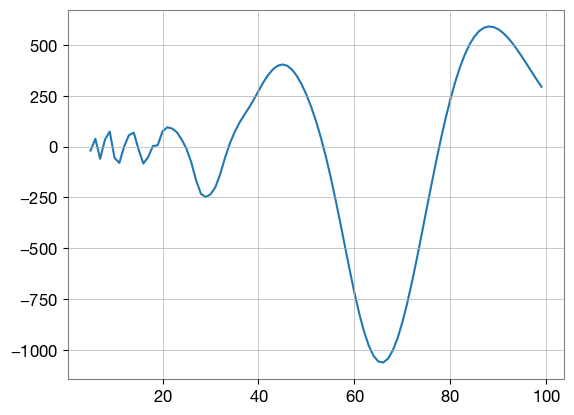

In [503]:
def tmpfun(inputs,iM1,iM2,iDist):
  lx=loss(L1Data,H1Data,iM1,iM2,2.19432,-1.2232,iDist)
  return lx

#m1range = np.arange(0.01,1,0.01)
m1range = np.arange(5,100,1)
m1scan  = []
for m1 in m1range:
    m1scan.append(tmpfun(x0,m1,0.8,400))
plt.plot(m1range,m1scan)
plt.show()

In [416]:
def prior(like,x):
    #Adjust the likelihood by the prior
    prior=np.ones(x.shape[0])
    idx = np.where((x[:,0] > 5) & (x[:,1] > 5) | (x[:,2] > 100))
    like[idx]+=np.log(prior[idx])
    return like

def mc_update(walkers, otherwalkers, logp0, Npars, a=2.0,iPrint=False):
    Nw = len(walkers)
    No = len(otherwalkers)
    Z = (((a - 1.0) * np.random.rand(Nw) + 1.0) ** 2.0) / a
    rint = np.random.randint(No, size=(Nw,))
    qt1 = otherwalkers[rint] - Z[:, np.newaxis] * (otherwalkers[rint] - walkers)
    logp1 = tmp_like(qt1)
    logp1 = prior(logp1,qt1)
    
    #Now do the usual Markov update
    #p_diff = (Npars - 1) * np.log(Z) + logp - logp0
    p_diff = logp1 - logp0

    rshape=np.random.rand(p_diff.shape[0])
    accept = p_diff > np.log(np.random.rand(p_diff.shape[0]))
    return qt1, logp1, accept

def proposal(q, logp, Nwalk, Npars):
    half = int(Nwalk / 2)
    first, second = slice(half), slice(half, Nwalk)

    # Alternate slices of the data fixing and updating
    for S0, S1 in [(first, second), (second, first)]:
        # Use stretch move to calculate the proposal
        q_new, logp_new, acc = mc_update(q[S0], q[S1], logp[S0], Npars)

        # Add accepted values into the chains
        if np.any(acc):
            logp[S0][acc] = logp_new[acc]
            q[S0][acc]    = q_new[acc]

    return q, logp

#def metropolis_hastings(iLikelihood,iPrior,iProposal,iAcceptance,xinit,data,niterations):
def metropolis_hastings_ensemble(xinit, logpinit, Npars, Nwalk, Nstep):
    samples = np.ndarray((Nwalk, Nstep, Npars))
    samples[:, 0, :] = np.array(xinit)

    lnprob = np.ndarray((Nwalk, Nstep))
    lnprob[:, 0] = np.array(logpinit)

    # Iterate over the Markov steps
    for i in range(1, Nstep):
        if i % 1000 == 0:
            print("Steps:",i)
        q, p = proposal(samples[:,i-1,:], lnprob[:,i-1], Nwalk, Npars)
        samples[:,i,:] = np.array(q)
        lnprob[:,i] = np.array(p)
    
    return samples, lnprob

def tmp_like(inputs):
    output = []
    for pInput in inputs:
        output.append(loss(L1Data,H1Data,pInput[0],pInput[1],2.19432,-1.2232,pInput[2]))
    return np.array(output)

xinit = np.array([20,20,400])
Npars = xinit.shape[0]
Nwalk = 100
Nstep = 500
q0    = np.array([xinit + 1.0*np.random.randn(Npars) for i in range(Nwalk)])
logp0 = tmp_like(q0)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,Npars,Nwalk,Nstep)

(9900, 3)


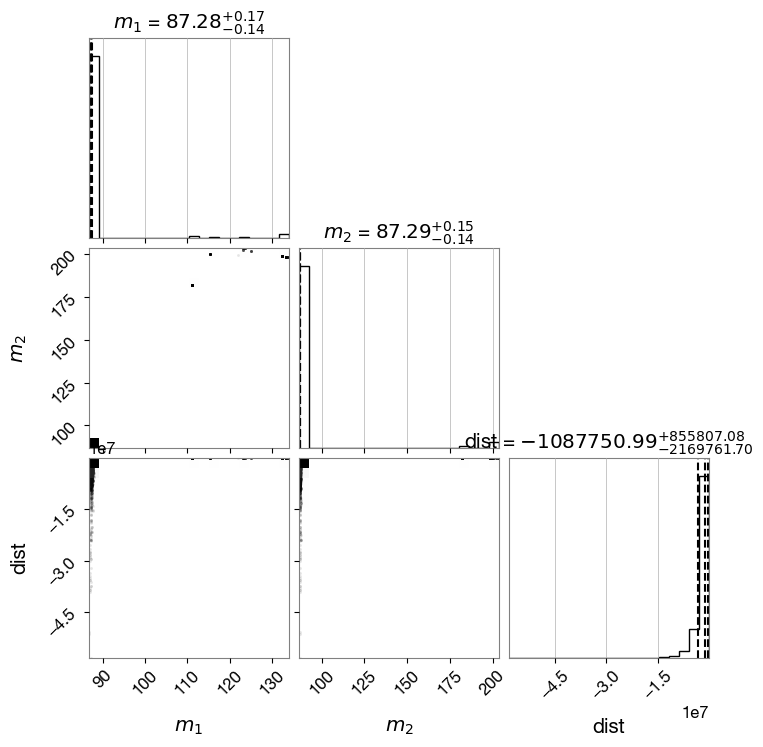

In [418]:
import corner 
labels = ['$m_{1}$','$m_{2}$','dist']
samples=accepted[:,-100:-1]
samples=np.reshape(samples,(samples.shape[0]*samples.shape[1],samples.shape[2]))
print(samples.shape)
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [534]:
from bilby.core.prior import Uniform

interferometers = [H1, L1]
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=10.0,maximum=500.)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.1,maximum=1.)
prior['phase']        = 1.3#Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers, waveform_generator, priors=prior,
    time_marginalization=False, phase_marginalization=False, distance_marginalization=False)

result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short3', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

00:07 bilby INFO    : Running for label 'GW150914', output will be saved to 'short3'
00:07 bilby INFO    : Using lal version 7.3.1
00:07 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.14;Id: c1be3b4393c305f7d4244b707604d603a10bc764;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
00:07 bilby INFO    : Using lalsimulation version 5.1.0
00:07 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.14;Id: c1be3b4393c305f7d4244b707604d603a10bc764;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
00:07 bilby INFO    : Analysis priors:
00:07 bilby INFO    : chirp_mass=Uniform(minimum=10.0, maximum=500.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
00:07 bilby INFO    : mass_ratio=Uniform(minimum=0.1, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
00:07 bilby INFO    : geocent_time

RuntimeError: Internal function call failed: Input domain error

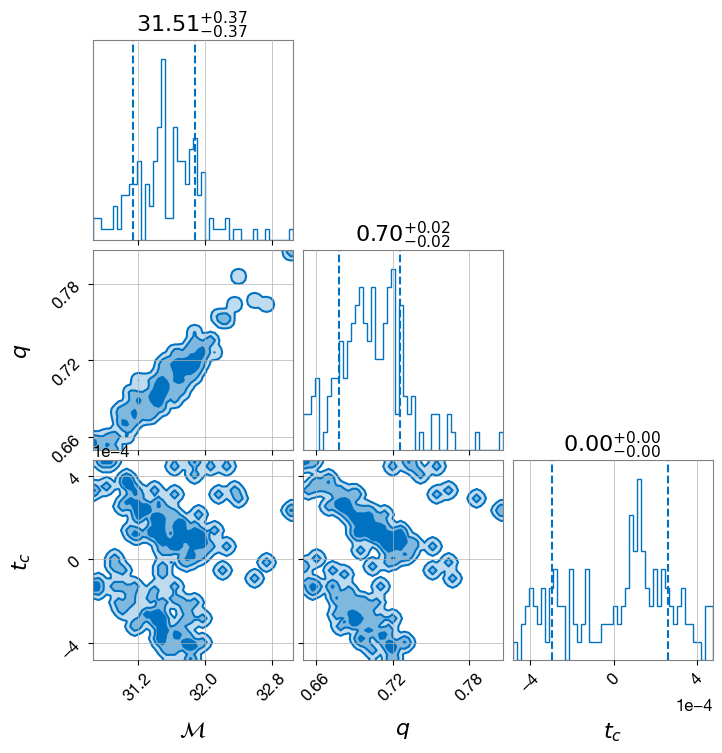

In [479]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time"], prior=True)

In [507]:
wvf0,_=generateWaveForm(30,0.8,0,0,410)
likelihood.log_likelihood_interferometer(wvf0,L1)

AttributeError: 'GravitationalWaveTransient' object has no attribute 'log_likelihood_interferometer'

In [508]:
likelihood.compute_per_detector_log_likelihood()

{'phase': 1.3,
 'a_1': 0.0,
 'a_2': 0.0,
 'tilt_1': 0.0,
 'tilt_2': 0.0,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'dec': -1.2232,
 'ra': 2.19432,
 'theta_jn': 1.89694,
 'psi': 0.532268,
 'luminosity_distance': 412.066,
 'chirp_mass': 31.389784334732163,
 'mass_ratio': 0.6917277335817724,
 'geocent_time': -0.0002714837021556217,
 'log_likelihood': 269.4422790886363,
 'log_prior': -inf,
 'reference_frequency': 50.0,
 'waveform_approximant': 'IMRPhenomPv2',
 'minimum_frequency': 20.0,
 'total_mass': 73.59084365059583,
 'mass_1': 43.50040623545686,
 'mass_2': 30.09043741513897,
 'H1_log_likelihood': 101.62599368237993,
 'L1_log_likelihood': -17.007129089805087}

In [509]:
tmp=likelihood.calculate_snrs(wvf0,H1)
print(tmp)
likelihood.compute_log_likelihood_from_snrs(likelihood.calculate_snrs(wvf0,H1))

GravitationalWaveTransient._CalculatedSNRs(d_inner_h=(-239.97324136190386+88.99730628670015j), optimal_snr_squared=111.8232569730746, complex_matched_filter_snr=(-22.69325268483144+8.416098179828332j), d_inner_h_array=None, optimal_snr_squared_array=None)


-295.88486984844116

In [514]:
wvf1=likelihood._compute_full_waveform(wvf0,H1)
H1.inner_product(signal=wvf1).real-H1.optimal_snr_squared(signal=wvf1)/2
print(tmp.d_inner_h.real-tmp.optimal_snr_squared/2.)
print(H1.inner_product(signal=wvf1).real,H1.optimal_snr_squared(signal=wvf1))

-295.88486984844116
-239.97324136190386 (111.8232569730746+0j)


In [515]:
#np.conj(wvf1)*
def loss(data1,data2,m1,m2,ra,dec,dist):
    L1SB,H1SB = asdSigBkg(m1,m2,ra,dec,dist)
    L1Chi2    = np.vdot(np.conj(L1SB),data1/L1.power_spectral_density_array[idxs])
    H1Chi2    = np.vdot(np.conj(H1SB),data2/H1.power_spectral_density_array[idxs])
    L1Chi2S   = np.vdot(np.conj(L1SB),L1SB/L1.power_spectral_density_array[idxs])
    H1Chi2S   = np.vdot(np.conj(H1SB),H1SB/H1.power_spectral_density_array[idxs])
    print("L1:",L1Chi2.real,"H1:",H1Chi2.real,"-",H1Chi2S.real,"M1:",m1,"M2:",m2,"Mag:",dist)
    return (4./duration)*(H1Chi2-H1Chi2S/2.).real

def fun(inputs):
  lx=loss(L1Data,H1Data,inputs[0],inputs[1],2.19432,-1.2232,inputs[2])
  return lx

xinit=np.array([30,0.8,410])
fun(xinit)

L1: 34.21650186691557 H1: -227.4559872341071 - 44.14392537456814 M1: 30.0 M2: 0.8 Mag: 410.0


-249.52794992139118

L1: -0.33707060212555273 H1: -0.18382159144330593 - -0.008988057091085043 M1: 40 M2: 0.01 Mag: 400
L1: -3.0316108872808085 H1: 10.105594125701838 - 0.20049220338910073 M1: 40 M2: 0.02 Mag: 400
L1: 11.029722242011593 H1: 1.0101228269570846 - -2.2619504613899544 M1: 40 M2: 0.03 Mag: 400
L1: -2.8759413806899747 H1: 42.030167544153755 - 3.436674217433276 M1: 40 M2: 0.04 Mag: 400
L1: -26.925433475961576 H1: -22.19075176850835 - -10.16081694413986 M1: 40 M2: 0.05 Mag: 400
L1: -31.279296557977773 H1: -80.19643588471533 - 4.624051378566959 M1: 40 M2: 0.060000000000000005 Mag: 400
L1: -40.33938637695963 H1: -82.5565161982887 - -4.25374975608479 M1: 40 M2: 0.06999999999999999 Mag: 400
L1: -7.004375294434967 H1: -69.53029822458691 - 8.285206125850006 M1: 40 M2: 0.08 Mag: 400
L1: -51.364681179070345 H1: -90.14875861316973 - -11.622780031724275 M1: 40 M2: 0.09 Mag: 400
L1: 25.79177489290559 H1: 11.131841505245678 - -20.590807954109934 M1: 40 M2: 0.09999999999999999 Mag: 400
L1: 65.77491004498216 H1

L1: 170.89746816542143 H1: 70.10792404367578 - 10.110714459109914 M1: 40 M2: 0.88 Mag: 400
L1: 173.24075392541812 H1: 61.95867288241866 - 5.804802892109649 M1: 40 M2: 0.89 Mag: 400
L1: 175.27959517839162 H1: 54.61452594826188 - 1.9214420382095625 M1: 40 M2: 0.9 Mag: 400
L1: 177.04153097948 H1: 48.06005896385272 - -1.5426497389594545 M1: 40 M2: 0.91 Mag: 400
L1: 178.55113489586552 H1: 42.277938483469455 - -4.594456537081669 M1: 40 M2: 0.92 Mag: 400
L1: 179.83011228342633 H1: 37.249531532855954 - -7.243500658854657 M1: 40 M2: 0.93 Mag: 400
L1: 180.89757124824212 H1: 32.955399175496964 - -9.500903044463342 M1: 40 M2: 0.9400000000000001 Mag: 400
L1: 181.77006817730316 H1: 29.375691873948686 - -11.378648155937327 M1: 40 M2: 0.9500000000000001 Mag: 400
L1: 182.46184075900135 H1: 26.4904613968422 - -12.889013587644143 M1: 40 M2: 0.9600000000000001 Mag: 400
L1: 182.98494889461736 H1: 24.27987545851679 - -14.044160880567745 M1: 40 M2: 0.97 Mag: 400
L1: 183.3494620107416 H1: 22.724360681865605 -

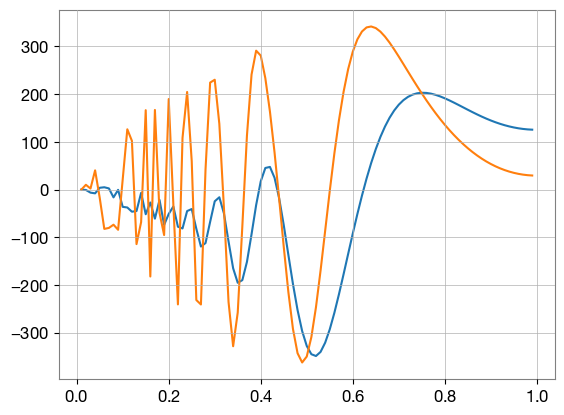

In [522]:
#np.conj(wvf1)*
def loss_ligo(m1,m2,ra,dec,dist):
    wvf0,_=generateWaveForm(m1,m2,ra,dec,dist)
    L1LL      = likelihood.compute_log_likelihood_from_snrs(likelihood.calculate_snrs(wvf0,L1))
    H1LL      = likelihood.compute_log_likelihood_from_snrs(likelihood.calculate_snrs(wvf0,H1))
    #print("L1:",L1LL,"H1:",H1LL,"M1:",m1,"M2:",m2,"Mag:",dist)
    return L1LL+H1LL

def tmpfun1(inputs,iM1,iM2,iDist):
  lx=loss_ligo(iM1,iM2,2.19432,-1.2232,iDist)
  return lx

def tmpfun2(inputs,iM1,iM2,iDist):
  lx=loss(L1Data,H1Data,iM1,iM2,2.19432,-1.2232,iDist)
  return lx

m1range = np.arange(0.01,1,0.01)
#m1range = np.arange(5,100,1)
m1scan1  = []
m1scan2  = []
for m1 in m1range:
    m1scan1.append(tmpfun1(x0,40,m1,400))
    m1scan2.append(tmpfun2(x0,40,m1,400))
plt.plot(m1range,m1scan1)
plt.plot(m1range,m1scan2)
plt.show()

In [528]:
def generateWaveForm(iMc,iMR,iRA,iDC,iD):
    #print(iMc,iMR,iRA,iDC,iD)
    lMc = np.max([iMc,10.])
    lMR = np.max([iMR,0.01])
    lD  = np.max([iD,50.])
    lMR = np.min([lMR,1.00])
    injection_parameters = dict(
    chirp_mass=lMc, mass_ratio=lMR, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=lD, theta_jn=1.89694, psi=0.532268,
    phase=0.0, geocent_time=time_of_event, ra=iRA, dec=iDC)
    polarizations_fd = waveform_generator.frequency_domain_strain(injection_parameters)
    return polarizations_fd,injection_parameters

def prior(like,x):
    #Adjust the likelihood by the prior
    prior=np.ones(x.shape[0])
    idx = np.where((x[:,0] > 5) & (x[:,1] > 0.01)  & (x[:,2] > 100) & (x[:,1] < 1.00))
    like[idx]+=np.log(prior[idx])
    return like

def tmp_like(inputs):
    output = []
    for pInput in inputs:
        output.append(loss_ligo(pInput[0],pInput[1],2.19432,-1.2232,pInput[2]))
    return np.array(output)

xinit = np.array([40,0.8,400])
Npars = xinit.shape[0]
Nwalk = 100
Nstep = 500
q0    = np.array([xinit + 1e-2*np.random.randn(Npars) for i in range(Nwalk)])
logp0 = tmp_like(q0)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,Npars,Nwalk,Nstep)

(9900, 3)


/Users/philipharris/miniconda3/lib/python3.10/site-packages/corner/core.py:788: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolor(X, Y, H.max() - H.T, cmap=density_cmap, **pcolor_kwargs)


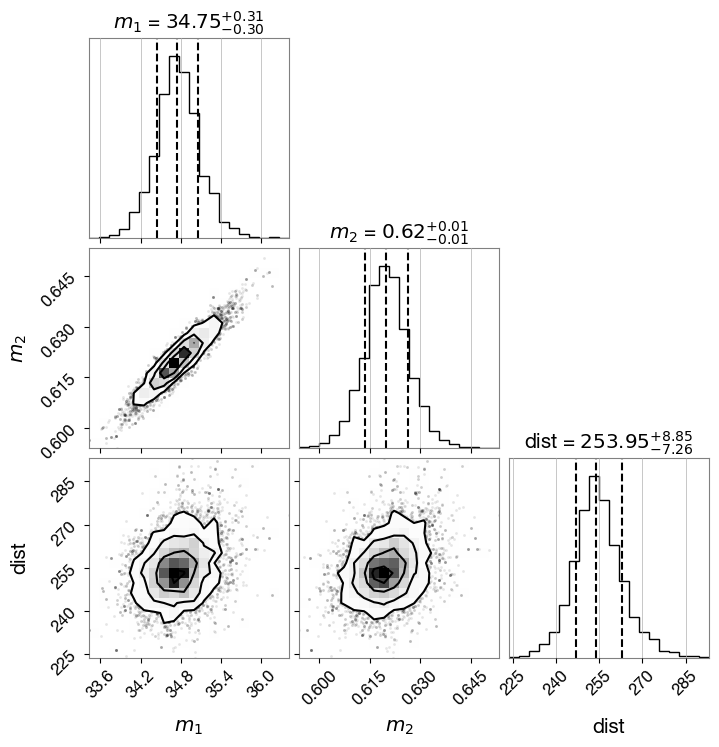

In [529]:
import corner 
labels = ['$m_{1}$','$m_{2}$','dist']
samples=accepted[:,-100:-1]
samples=np.reshape(samples,(samples.shape[0]*samples.shape[1],samples.shape[2]))
print(samples.shape)
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [540]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers, waveform_generator, priors=prior,time_marginalization=False, phase_marginalization=False, distance_marginalization=False)
#np.conj(wvf1)*
def loss_ligo(m1,m2,ra,dec,dist):
    wvf0,_=generateWaveForm(m1,m2,ra,dec,dist)
    L1LL      = likelihood.compute_log_likelihood_from_snrs(likelihood.calculate_snrs(wvf0,L1))
    H1LL      = likelihood.compute_log_likelihood_from_snrs(likelihood.calculate_snrs(wvf0,H1))
    #print("L1:",L1LL,"H1:",H1LL,"M1:",m1,"M2:",m2,"Mag:",dist)
    return L1LL+H1LL

def generateWaveForm(iMc,iMR,iRA,iDC,iD):
    #print(iMc,iMR,iRA,iDC,iD)
    lMc = np.max([iMc,10.])
    lMR = np.max([iMR,0.01])
    lD  = np.max([iD,50.])
    lMR = np.min([lMR,1.00])
    injection_parameters = dict(
    chirp_mass=lMc, mass_ratio=lMR, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=lD, theta_jn=1.89694, psi=0.532268,
    phase=0.0, geocent_time=time_of_event, ra=iRA, dec=iDC)
    polarizations_fd = waveform_generator.frequency_domain_strain(injection_parameters)
    return polarizations_fd,injection_parameters

def tmp_like(inputs):
    return -1*loss_ligo(inputs[0],inputs[1],2.19432,-1.2232,inputs[2])

cons= ({'type': 'ineq', 'fun': lambda x:  x[0]},
       {'type': 'ineq', 'fun': lambda x:  x[1]},
       {'type': 'ineq', 'fun': lambda x:  x[2]})
constraints=cons
bnds = ((0.1, None), (0.1, None), (10, None))
sol=minimize(tmp_like,xinit,bounds=bnds,method='Nelder-Mead', options={'gtol': 1e-3, 'disp': True})
print(sol)

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_70505/4154040523.py:31: OptimizeWarning: Unknown solver options: gtol
  sol=minimize(tmp_like,xinit,bounds=bnds,method='Nelder-Mead', options={'gtol': 1e-3, 'disp': True})


KeyError: 'ra'